# HW1

## Задание по сравнению методов градиентного бустинга

Шаги:
1. EDA (Exploratory Data Analysis)
2. Preprocessing & Feature Engineering
3. Сравнение 4 вариантов градиентного бустинга: sklearn, XGBoost, CatBoost, LightGBM

In [64]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, cross_val_score
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score, roc_auc_score, classification_report, confusion_matrix
import xgboost as xgb
from catboost import CatBoostClassifier
import lightgbm as lgb
import warnings
warnings.filterwarnings('ignore')

plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette('husl')
%matplotlib inline

# Часть 1. EDA (Exploratory Data Analysis)

Используем датасет Telco Customer Churn для предсказания оттока клиентов

In [2]:
# Загрузка данных
url = 'https://raw.githubusercontent.com/IBM/telco-customer-churn-on-icp4d/master/data/Telco-Customer-Churn.csv'
df = pd.read_csv(url)

print(f'Размер датасета: {df.shape}')
print(f'\nПервые строки:')
df.head()

Размер датасета: (7043, 21)

Первые строки:


,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [3]:
# Информация о типах данных и пропущенных значениях
print('Информация о датасете:')
df.info()
print('\n' + '='*50)
print('\nПропущенные значения:')
print(df.isnull().sum())
print('\n' + '='*50)
print('\nСтатистика по числовым признакам:')
df.describe()

Информация о датасете:
<class 'pandas.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   str    
 1   gender            7043 non-null   str    
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   str    
 4   Dependents        7043 non-null   str    
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   str    
 7   MultipleLines     7043 non-null   str    
 8   InternetService   7043 non-null   str    
 9   OnlineSecurity    7043 non-null   str    
 10  OnlineBackup      7043 non-null   str    
 11  DeviceProtection  7043 non-null   str    
 12  TechSupport       7043 non-null   str    
 13  StreamingTV       7043 non-null   str    
 14  StreamingMovies   7043 non-null   str    
 15  Contract          7043 non-null   str    
 16  PaperlessBilling  7043 non-nul

,SeniorCitizen,tenure,MonthlyCharges
count,7043.000000,7043.000000,7043.000000
mean,0.162147,32.371149,64.761692
std,0.368612,24.559481,30.090047
min,0.000000,0.000000,18.250000
25%,0.000000,9.000000,35.500000
50%,0.000000,29.000000,70.350000
75%,0.000000,55.000000,89.850000
max,1.000000,72.000000,118.750000


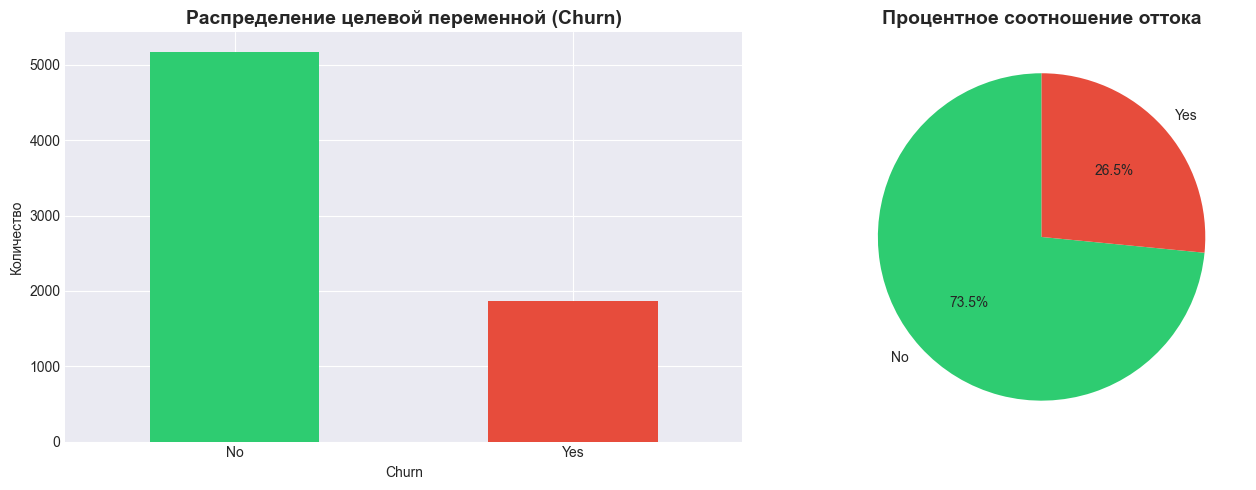

Процент оттока клиентов: 26.54%


In [4]:
# Распределение целевой переменной
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

df['Churn'].value_counts().plot(kind='bar', ax=axes[0], color=['#2ecc71', '#e74c3c'])
axes[0].set_title('Распределение целевой переменной (Churn)', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Churn')
axes[0].set_ylabel('Количество')
axes[0].set_xticklabels(['No', 'Yes'], rotation=0)

churn_pct = df['Churn'].value_counts(normalize=True) * 100
axes[1].pie(churn_pct, labels=['No', 'Yes'], autopct='%1.1f%%', startangle=90, colors=['#2ecc71', '#e74c3c'])
axes[1].set_title('Процентное соотношение оттока', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.show()

print(f'Процент оттока клиентов: {churn_pct["Yes"]:.2f}%')

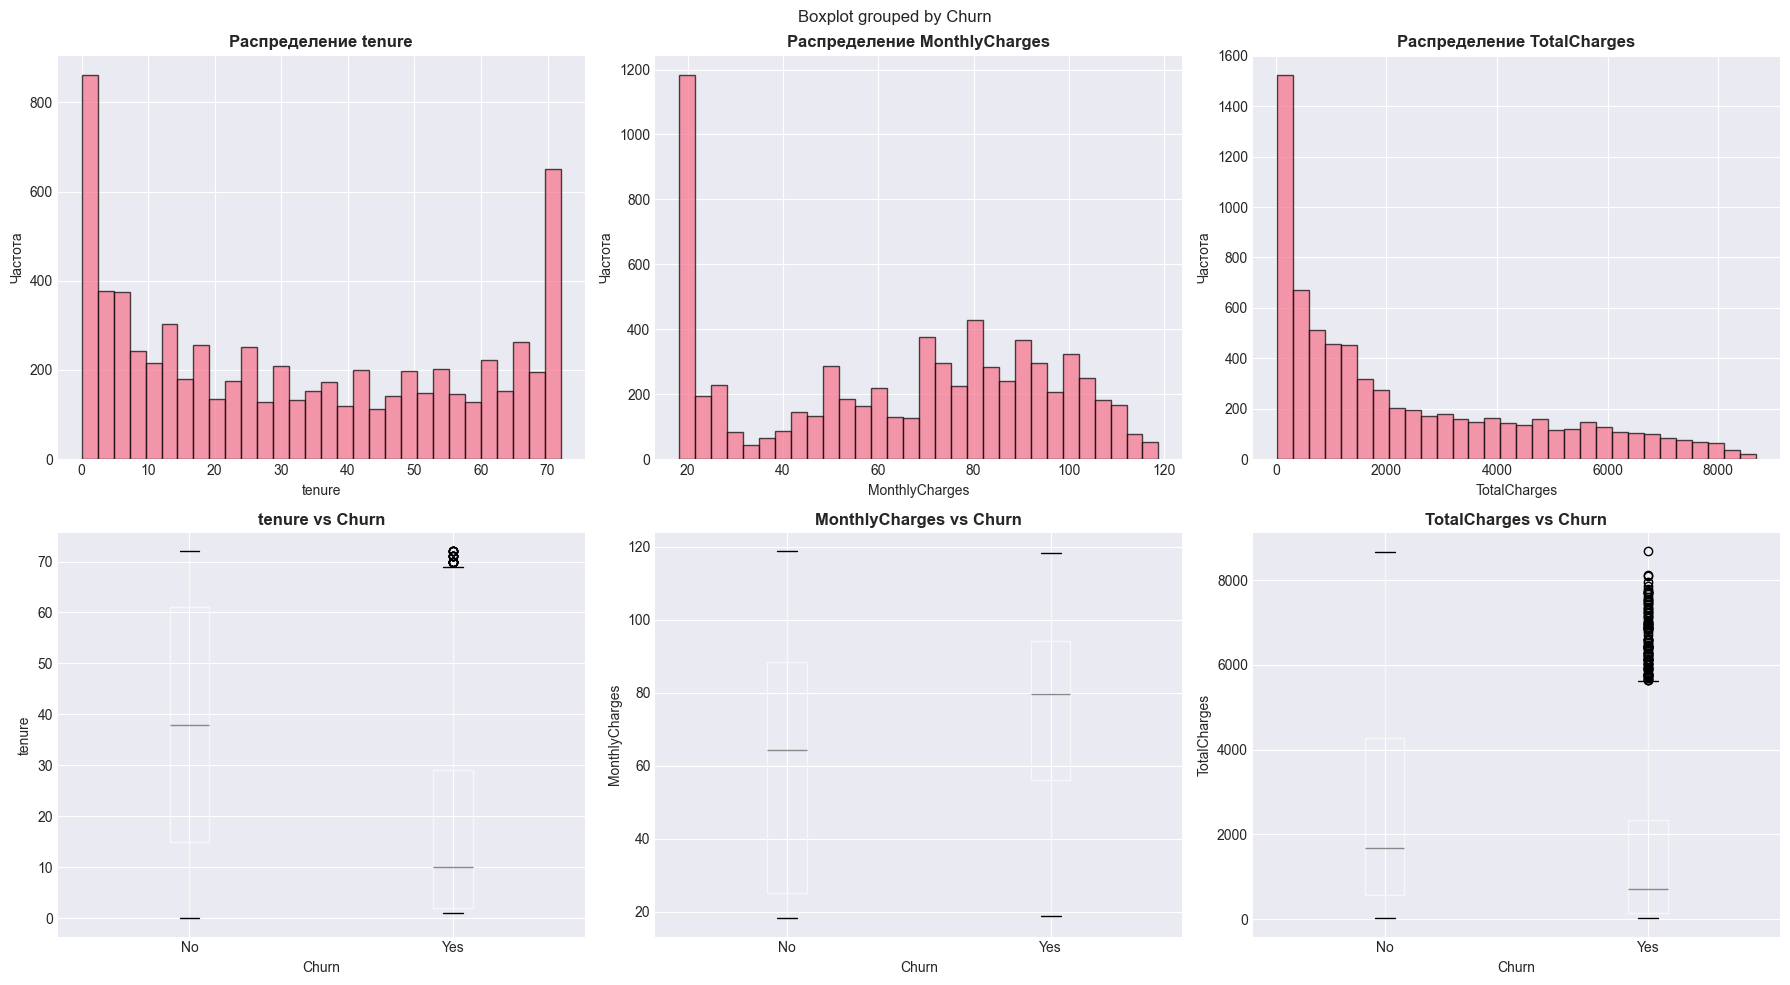

In [6]:
# Анализ числовых признаков
numeric_features = ['tenure', 'MonthlyCharges', 'TotalCharges']

# Конвертируем TotalCharges в числовой формат
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')

fig, axes = plt.subplots(2, 3, figsize=(18, 10))
axes = axes.ravel()

for idx, col in enumerate(numeric_features):
    # Распределение
    axes[idx].hist(df[col].dropna(), bins=30, edgecolor='black', alpha=0.7)
    axes[idx].set_title(f'Распределение {col}', fontweight='bold')
    axes[idx].set_xlabel(col)
    axes[idx].set_ylabel('Частота')
    
    # Boxplot по Churn
    df.boxplot(column=col, by='Churn', ax=axes[idx+3])
    axes[idx+3].set_title(f'{col} vs Churn', fontweight='bold')
    axes[idx+3].set_xlabel('Churn')
    axes[idx+3].set_ylabel(col)
    plt.sca(axes[idx+3])
    plt.xticks([1, 2], ['No', 'Yes'])

plt.tight_layout()
plt.show()

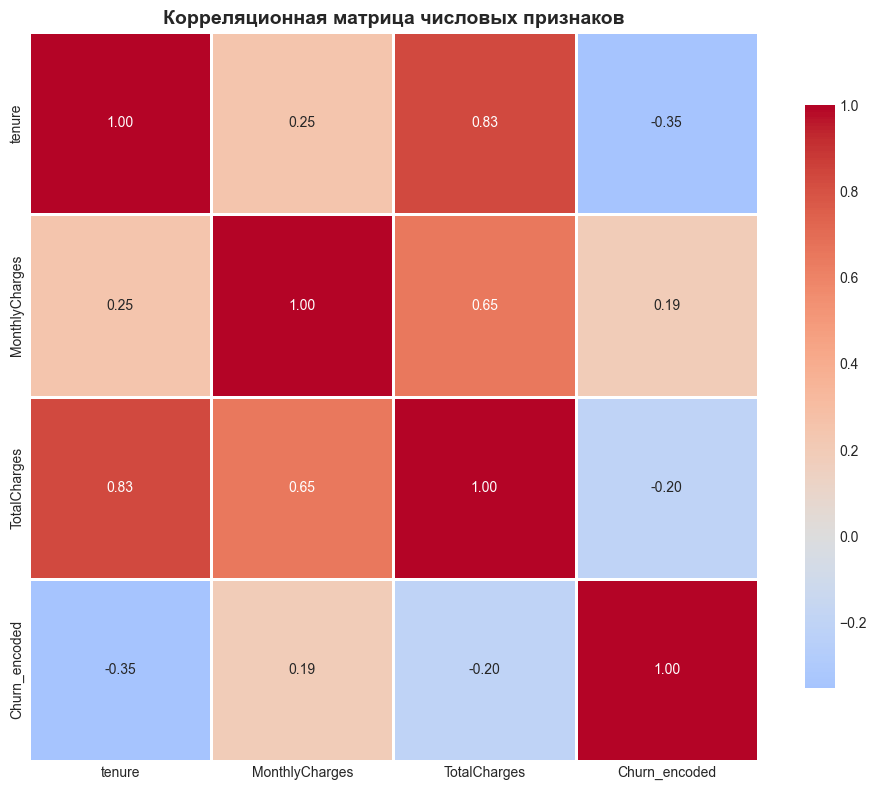

In [7]:
# Корреляционная матрица
df_numeric = df[numeric_features].copy()
df_numeric['Churn_encoded'] = (df['Churn'] == 'Yes').astype(int)

plt.figure(figsize=(10, 8))
sns.heatmap(df_numeric.corr(), annot=True, fmt='.2f', cmap='coolwarm', center=0, 
            square=True, linewidths=1, cbar_kws={"shrink": 0.8})
plt.title('Корреляционная матрица числовых признаков', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

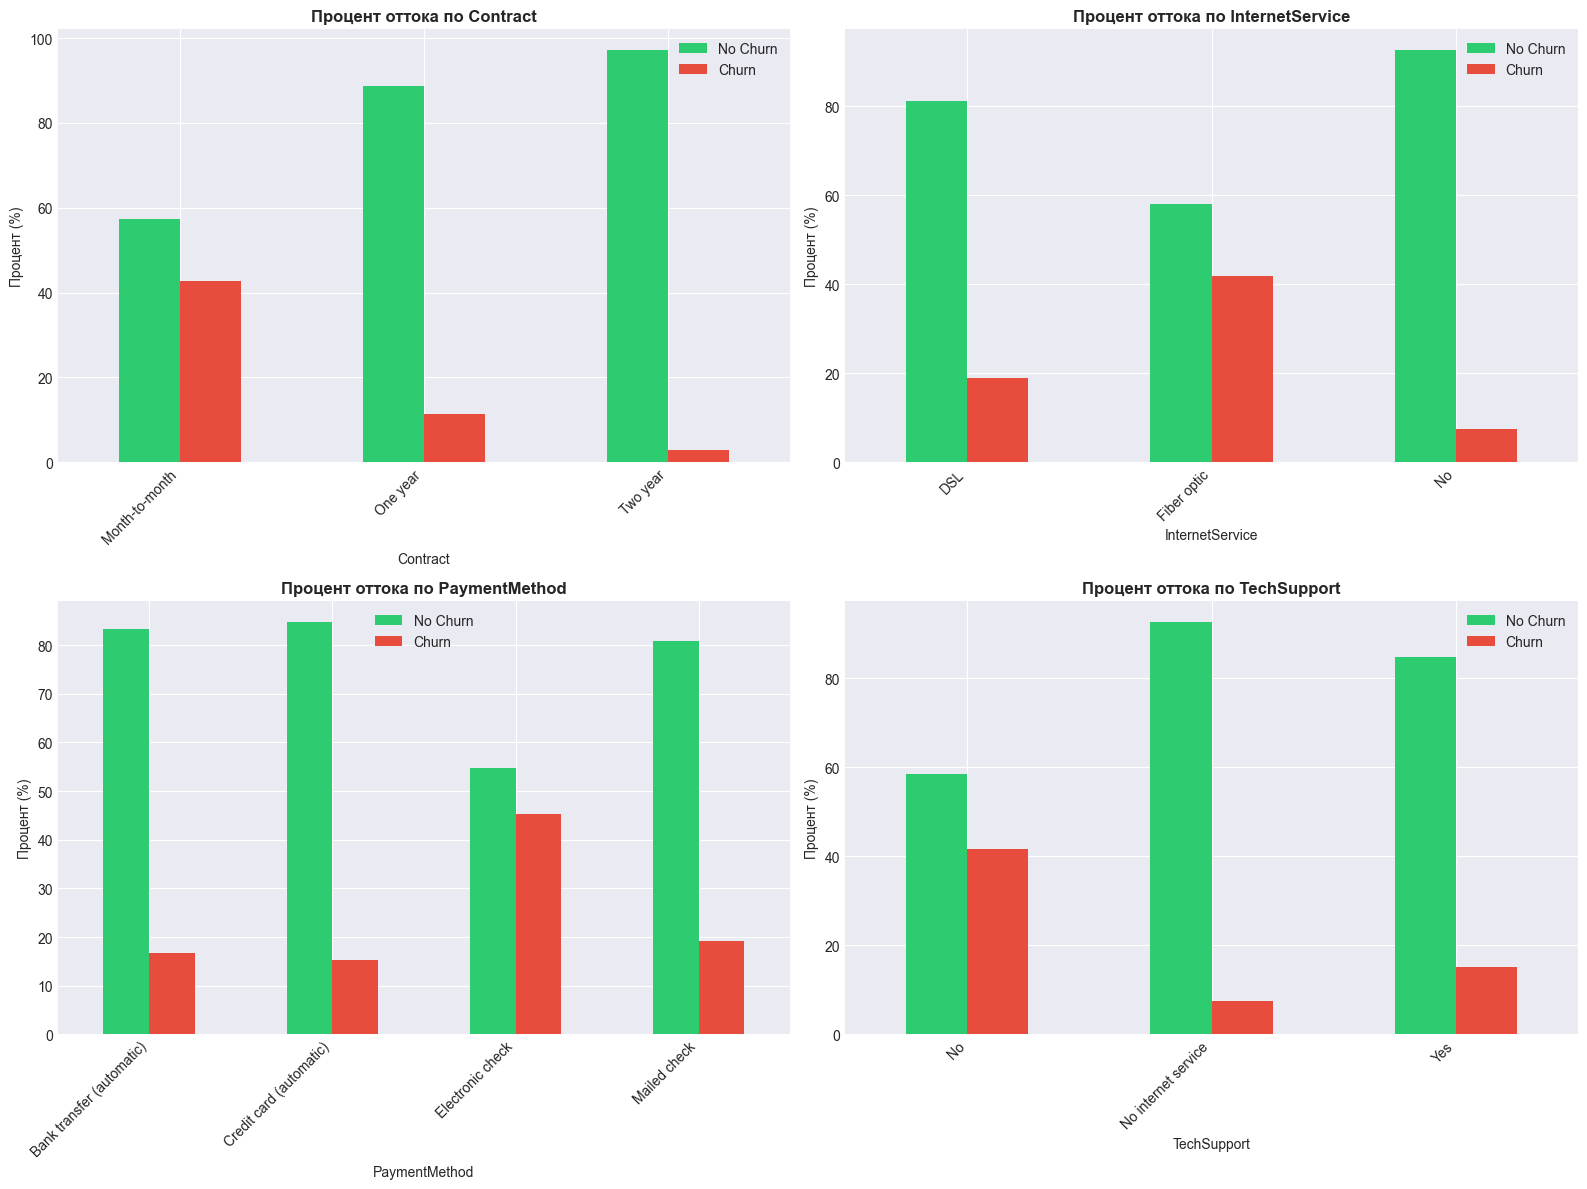

In [8]:
# Анализ категориальных признаков
categorical_features = ['gender', 'SeniorCitizen', 'Partner', 'Dependents', 
                       'PhoneService', 'MultipleLines', 'InternetService',
                       'OnlineSecurity', 'OnlineBackup', 'DeviceProtection',
                       'TechSupport', 'StreamingTV', 'StreamingMovies',
                       'Contract', 'PaperlessBilling', 'PaymentMethod']

# Выбираем несколько наиболее интересных для визуализации
features_to_plot = ['Contract', 'InternetService', 'PaymentMethod', 'TechSupport']

fig, axes = plt.subplots(2, 2, figsize=(16, 12))
axes = axes.ravel()

for idx, feature in enumerate(features_to_plot):
    churn_by_feature = pd.crosstab(df[feature], df['Churn'], normalize='index') * 100
    churn_by_feature.plot(kind='bar', ax=axes[idx], color=['#2ecc71', '#e74c3c'])
    axes[idx].set_title(f'Процент оттока по {feature}', fontweight='bold', fontsize=12)
    axes[idx].set_xlabel(feature)
    axes[idx].set_ylabel('Процент (%)')
    axes[idx].legend(['No Churn', 'Churn'])
    axes[idx].set_xticklabels(axes[idx].get_xticklabels(), rotation=45, ha='right')

plt.tight_layout()
plt.show()

# Часть 2. Preprocessing & Feature Engineering

In [9]:
# Создаем копию датасета для обработки
df_processed = df.copy()

# Удаляем customerID (не несет информационной нагрузки)
df_processed = df_processed.drop('customerID', axis=1)

# Обрабатываем TotalCharges
df_processed['TotalCharges'] = pd.to_numeric(df_processed['TotalCharges'], errors='coerce')
df_processed['TotalCharges'].fillna(df_processed['TotalCharges'].median(), inplace=True)

print(f'Размер обработанного датасета: {df_processed.shape}')
print(f'Пропущенные значения после обработки: {df_processed.isnull().sum().sum()}')

Размер обработанного датасета: (7043, 20)
Пропущенные значения после обработки: 11


In [16]:
# Feature Engineering: создаем новые признаки

# 1. Средняя стоимость за месяц существования
df_processed['AvgMonthlyCharges'] = df_processed['TotalCharges'] / (df_processed['tenure'] + 1)

# 2. Бинарный признак: есть ли какие-либо дополнительные услуги
service_cols = ['OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies']
df_processed['HasServices'] = (df_processed[service_cols] == 'Yes').sum(axis=1)

# 3. Группировка по продолжительности контракта
df_processed['TenureGroup'] = pd.cut(df_processed['tenure'], 
                                     bins=[0, 12, 24, 48, 72], 
                                     labels=['0-1yr', '1-2yr', '2-4yr', '4-6yr'])

# 4. Отношение общих платежей к месячным
df_processed['ChargesRatio'] = df_processed['TotalCharges'] / (df_processed['MonthlyCharges'] + 1)

print('Новые признаки созданы:')
print(df_processed[['AvgMonthlyCharges', 'HasServices', 'TenureGroup', 'ChargesRatio']].head())

Новые признаки созданы:
   AvgMonthlyCharges  HasServices TenureGroup  ChargesRatio
0          14.925000            0       0-1yr      0.967585
1          53.985714            0       2-4yr     32.605695
2          36.050000            0       0-1yr      1.971741
3          40.016304            0       2-4yr     42.511547
4          50.550000            0       0-1yr      2.115063


In [49]:
# Label Encoding для категориальных переменных
le = LabelEncoder()

# Находим ВСЕ нечисловые колонки (и object, и category)
categorical_cols = df_processed.select_dtypes(include=['object', 'category']).columns.tolist()
print(f'Категориальные признаки для кодирования: {categorical_cols}')

for col in categorical_cols:
    if col != 'Churn':  # Целевую переменную кодируем отдельно
        # Конвертируем в строку на случай если это category type
        df_processed[col] = le.fit_transform(df_processed[col].astype(str))
        print(f'Закодирован признак: {col}')

# Целевая переменная
df_processed['Churn'] = le.fit_transform(df_processed['Churn'])

Категориальные признаки для кодирования: []


In [50]:
#Проверка пропущенных значений
missing = df_processed.isnull().sum()
print(f'Всего пропущенных значений: {missing.sum()}')

if missing.sum() > 0:
    print('\nПропущенные значения по колонкам:')
    print(missing[missing > 0])
    
    print('\nЗаполяем пропущенные значения медианой для числовых признаков:')
    numeric_cols = df_processed.select_dtypes(include=['int64', 'float64']).columns
    for col in numeric_cols:
        if df_processed[col].isnull().sum() > 0:
            median_value = df_processed[col].median()
            df_processed[col].fillna(median_value, inplace=True)
            print(f' {col}: заполнено медианой = {median_value:.2f}')
    
    print('\nВсе пропущенные значения обработаны')
    print(f'Проверка: осталось NaN = {df_processed.isnull().sum().sum()}')
else:
    print('\nПропущенных значений не обнаружено')

Всего пропущенных значений: 33

Пропущенные значения по колонкам:
TotalCharges         11
AvgMonthlyCharges    11
ChargesRatio         11
dtype: int64

Заполяем пропущенные значения медианой для числовых признаков:
 TotalCharges: заполнено медианой = 1397.47
 AvgMonthlyCharges: заполнено медианой = 61.07
 ChargesRatio: заполнено медианой = 28.23

Все пропущенные значения обработаны
Проверка: осталось NaN = 33


In [51]:
# Разделение на признаки и целевую переменную
X = df_processed.drop('Churn', axis=1)
y = df_processed['Churn']

# Разделение на train и test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print(f'Размер обучающей выборки: {X_train.shape}')
print(f'Размер тестовой выборки: {X_test.shape}')
print(f'\nРаспределение классов в обучающей выборке:')
print(y_train.value_counts(normalize=True))
print(f'\nРаспределение классов в тестовой выборке:')
print(y_test.value_counts(normalize=True))

Размер обучающей выборки: (5634, 23)
Размер тестовой выборки: (1409, 23)

Распределение классов в обучающей выборке:
Churn
0    0.734647
1    0.265353
Name: proportion, dtype: float64

Распределение классов в тестовой выборке:
Churn
0    0.734564
1    0.265436
Name: proportion, dtype: float64


# Часть 3. Who's the mightiest of them all?

## 3.1 Модели "из коробки"

In [52]:
# Словарь для хранения результатов
results = {}

def evaluate_model(name, model, X_train, X_test, y_train, y_test):
    """Обучение и оценка модели"""
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    y_pred_proba = model.predict_proba(X_test)[:, 1]
    
    accuracy = accuracy_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_pred_proba)
    
    return {
        'accuracy': accuracy,
        'roc_auc': roc_auc,
        'model': model
    }

In [53]:
# Проверяем NaN в train/test данных
print(f'\nФорма X_train: {X_train.shape}')
print(f'Форма X_test: {X_test.shape}')

print(f'\nПропущенные значения в X_train:')
nan_train = X_train.isnull().sum()
print(nan_train[nan_train > 0])
print(f'Всего NaN в X_train: {nan_train.sum()}')

print(f'\nПропущенные значения в X_test:')
nan_test = X_test.isnull().sum()
print(nan_test[nan_test > 0])
print(f'Всего NaN в X_test: {nan_test.sum()}')

# ИСПРАВЛЯЕМ: заполняем NaN если они есть
if X_train.isnull().sum().sum() > 0 or X_test.isnull().sum().sum() > 0:
    print('\nЗаполняем медианой пропущенные значения:')
    
    from sklearn.impute import SimpleImputer
    imputer = SimpleImputer(strategy='median')
    
    # Fit на train, transform на train и test
    X_train_clean = pd.DataFrame(
        imputer.fit_transform(X_train),
        columns=X_train.columns,
        index=X_train.index
    )
    
    X_test_clean = pd.DataFrame(
        imputer.transform(X_test),
        columns=X_test.columns,
        index=X_test.index
    )
    
    # Заменяем оригинальные данные
    X_train = X_train_clean
    X_test = X_test_clean
    
    print(f'После очистки NaN в X_train: {X_train.isnull().sum().sum()}')
    print(f'После очистки NaN в X_test: {X_test.isnull().sum().sum()}')
else:
    print('\nNaN не обнаружены')



Форма X_train: (5634, 23)
Форма X_test: (1409, 23)

Пропущенные значения в X_train:
TotalCharges         8
AvgMonthlyCharges    8
ChargesRatio         8
dtype: int64
Всего NaN в X_train: 24

Пропущенные значения в X_test:
TotalCharges         3
AvgMonthlyCharges    3
ChargesRatio         3
dtype: int64
Всего NaN в X_test: 9

Заполняем медианой пропущенные значения:
После очистки NaN в X_train: 0
После очистки NaN в X_test: 0


In [54]:
# 1. Sklearn GradientBoostingClassifier
print('Обучение Sklearn GradientBoosting...')
gb_sklearn = GradientBoostingClassifier(random_state=42)
results['Sklearn_GB_default'] = evaluate_model('Sklearn GB', gb_sklearn, X_train, X_test, y_train, y_test)
print(f"Accuracy: {results['Sklearn_GB_default']['accuracy']:.4f}")
print(f"ROC-AUC: {results['Sklearn_GB_default']['roc_auc']:.4f}")
print('=' * 50)

Обучение Sklearn GradientBoosting...
Accuracy: 0.8091
ROC-AUC: 0.8429


In [55]:
# 2. XGBoost
print('Обучение XGBoost...')
xgb_model = xgb.XGBClassifier(random_state=42, eval_metric='logloss')
results['XGBoost_default'] = evaluate_model('XGBoost', xgb_model, X_train, X_test, y_train, y_test)
print(f"Accuracy: {results['XGBoost_default']['accuracy']:.4f}")
print(f"ROC-AUC: {results['XGBoost_default']['roc_auc']:.4f}")
print('=' * 50)

Обучение XGBoost...
Accuracy: 0.7842
ROC-AUC: 0.8136


In [56]:
# 3. CatBoost
print('Обучение CatBoost...')
cat_model = CatBoostClassifier(random_state=42, verbose=0)
results['CatBoost_default'] = evaluate_model('CatBoost', cat_model, X_train, X_test, y_train, y_test)
print(f"Accuracy: {results['CatBoost_default']['accuracy']:.4f}")
print(f"ROC-AUC: {results['CatBoost_default']['roc_auc']:.4f}")
print('=' * 50)

Обучение CatBoost...
Accuracy: 0.7935
ROC-AUC: 0.8378


In [57]:
# 4. LightGBM
print('Обучение LightGBM...')
lgb_model = lgb.LGBMClassifier(random_state=42, verbose=-1)
results['LightGBM_default'] = evaluate_model('LightGBM', lgb_model, X_train, X_test, y_train, y_test)
print(f"Accuracy: {results['LightGBM_default']['accuracy']:.4f}")
print(f"ROC-AUC: {results['LightGBM_default']['roc_auc']:.4f}")
print('=' * 50)

Обучение LightGBM...
Accuracy: 0.7935
ROC-AUC: 0.8328


In [58]:
# Сравнение результатов моделей "из коробки"
default_results = pd.DataFrame({
    'Model': ['Sklearn GB', 'XGBoost', 'CatBoost', 'LightGBM'],
    'Accuracy': [results['Sklearn_GB_default']['accuracy'],
                results['XGBoost_default']['accuracy'],
                results['CatBoost_default']['accuracy'],
                results['LightGBM_default']['accuracy']],
    'ROC-AUC': [results['Sklearn_GB_default']['roc_auc'],
               results['XGBoost_default']['roc_auc'],
               results['CatBoost_default']['roc_auc'],
               results['LightGBM_default']['roc_auc']]
}).sort_values('ROC-AUC', ascending=False)

print('\n' + '='*60)
print('РЕЗУЛЬТАТЫ МОДЕЛЕЙ "ИЗ КОРОБКИ"')
print('='*60)
print(default_results.to_string(index=False))
print('='*60)
print(f'\nЛидер по ROC-AUC: {default_results.iloc[0]["Model"]} ({default_results.iloc[0]["ROC-AUC"]:.4f})')


РЕЗУЛЬТАТЫ МОДЕЛЕЙ "ИЗ КОРОБКИ"
     Model  Accuracy  ROC-AUC
Sklearn GB  0.809084 0.842937
  CatBoost  0.793471 0.837791
  LightGBM  0.793471 0.832795
   XGBoost  0.784244 0.813583

Лидер по ROC-AUC: Sklearn GB (0.8429)


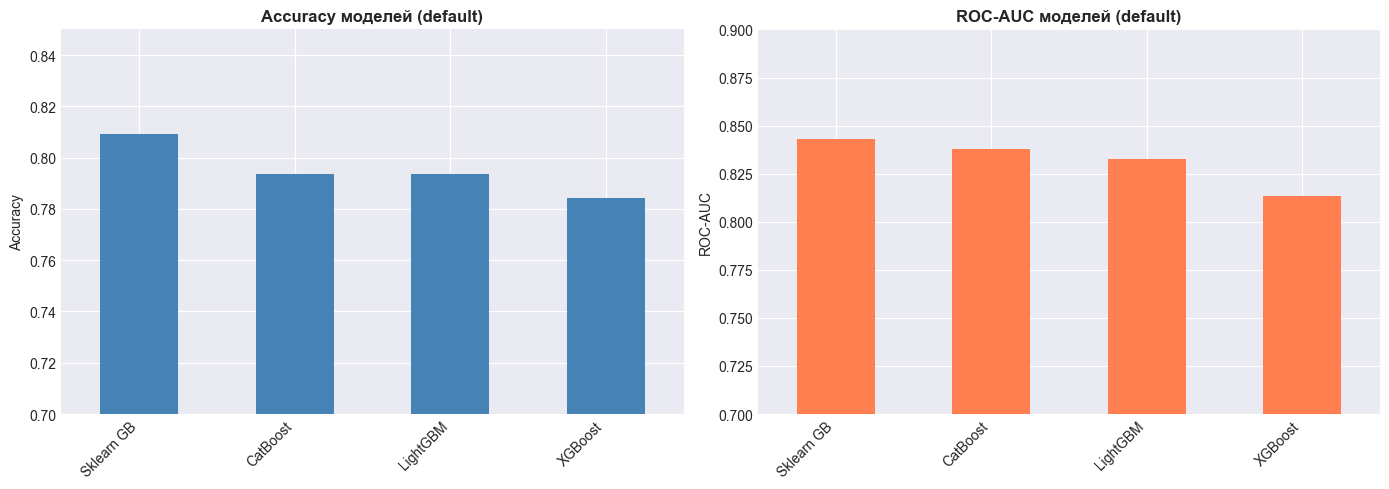

In [59]:
# Визуализация результатов
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

default_results.plot(x='Model', y='Accuracy', kind='bar', ax=axes[0], color='steelblue', legend=False)
axes[0].set_title('Accuracy моделей (default)', fontweight='bold', fontsize=12)
axes[0].set_ylabel('Accuracy')
axes[0].set_xlabel('')
axes[0].set_xticklabels(default_results['Model'], rotation=45, ha='right')
axes[0].set_ylim([0.7, 0.85])

default_results.plot(x='Model', y='ROC-AUC', kind='bar', ax=axes[1], color='coral', legend=False)
axes[1].set_title('ROC-AUC моделей (default)', fontweight='bold', fontsize=12)
axes[1].set_ylabel('ROC-AUC')
axes[1].set_xlabel('')
axes[1].set_xticklabels(default_results['Model'], rotation=45, ha='right')
axes[1].set_ylim([0.7, 0.9])

plt.tight_layout()
plt.show()

## 3.2 Настройка гиперпараметров

In [60]:
# 1. Sklearn GradientBoosting - настройка
print('Настройка Sklearn GradientBoosting...')

param_grid_sklearn = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.05, 0.1],
    'max_depth': [3, 5, 7],
    'subsample': [0.8, 1.0],
    'max_features': ['sqrt', 'log2']
}

gb_sklearn_tuned = GridSearchCV(
    GradientBoostingClassifier(random_state=42),
    param_grid_sklearn,
    cv=3,
    scoring='roc_auc',
    n_jobs=-1,
    verbose=1
)

gb_sklearn_tuned.fit(X_train, y_train)
results['Sklearn_GB_tuned'] = evaluate_model('Sklearn GB Tuned', gb_sklearn_tuned.best_estimator_, 
                                             X_train, X_test, y_train, y_test)

print(f'\nЛучшие параметры: {gb_sklearn_tuned.best_params_}')
print(f"Accuracy: {results['Sklearn_GB_tuned']['accuracy']:.4f}")
print(f"ROC-AUC: {results['Sklearn_GB_tuned']['roc_auc']:.4f}")
print('=' * 50)

Настройка Sklearn GradientBoosting...
Fitting 3 folds for each of 108 candidates, totalling 324 fits

Лучшие параметры: {'learning_rate': 0.05, 'max_depth': 3, 'max_features': 'sqrt', 'n_estimators': 100, 'subsample': 1.0}
Accuracy: 0.8041
ROC-AUC: 0.8468


In [62]:
# 2. XGBoost - настройка
print('Настройка XGBoost...')

param_grid_xgb = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.05, 0.1],
    'max_depth': [3, 5, 7],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0]
}

xgb_tuned = GridSearchCV(
    xgb.XGBClassifier(random_state=42, eval_metric='logloss'),
    param_grid_xgb,
    cv=3,
    scoring='roc_auc',
    n_jobs=-1,
    verbose=1
)

xgb_tuned.fit(X_train, y_train)
results['XGBoost_tuned'] = evaluate_model('XGBoost Tuned', xgb_tuned.best_estimator_, 
                                         X_train, X_test, y_train, y_test)

print(f'\nЛучшие параметры: {xgb_tuned.best_params_}')
print(f"Accuracy: {results['XGBoost_tuned']['accuracy']:.4f}")
print(f"ROC-AUC: {results['XGBoost_tuned']['roc_auc']:.4f}")
print('=' * 50)

Настройка XGBoost...
Fitting 3 folds for each of 108 candidates, totalling 324 fits

Лучшие параметры: {'colsample_bytree': 0.8, 'learning_rate': 0.01, 'max_depth': 5, 'n_estimators': 300, 'subsample': 0.8}
Accuracy: 0.8034
ROC-AUC: 0.8468


In [72]:
# 3. CatBoost - настройка
print('Настройка CatBoost...')

# Расширенная сетка параметров
param_grid = {
    'iterations': [200, 300, 500],
    'learning_rate': [0.01, 0.03, 0.05, 0.1],
    'depth': [4, 6, 8, 10],
    'l2_leaf_reg': [1, 3, 5],
    'subsample': [0.8, 0.9, 1.0]
}

best_score = 0
best_params = None
best_model = None

# Подсчет комбинаций
total = (len(param_grid['iterations']) * len(param_grid['learning_rate']) * 
         len(param_grid['depth']) * len(param_grid['l2_leaf_reg']) * 
         len(param_grid['subsample']))

print(f'Всего комбинаций: {total}')
print('Используем случайный поиск для ускорения...\n')

import random
random.seed(42)

# Случайный поиск - проверяем 30 лучших комбинаций
n_iter = min(30, total)
tested = 0

for i in range(n_iter):
    tested += 1
    print(f'Тестирование {tested}/{n_iter}...', end='\r')
    
    # Случайный выбор параметров
    params = {
        'iterations': random.choice(param_grid['iterations']),
        'learning_rate': random.choice(param_grid['learning_rate']),
        'depth': random.choice(param_grid['depth']),
        'l2_leaf_reg': random.choice(param_grid['l2_leaf_reg']),
        'subsample': random.choice(param_grid['subsample']),
        'random_state': 42,
        'verbose': 0
    }
    
    try:
        model = CatBoostClassifier(**params)
        model.fit(X_train, y_train, verbose=0)
        
        # Оценка на валидации
        y_pred_proba = model.predict_proba(X_test)[:, 1]
        score = roc_auc_score(y_test, y_pred_proba)
        
        if score > best_score:
            best_score = score
            best_params = params.copy()
            best_model = model
            print(f'\nЛучший результат ROC-AUC: {score:.4f}')
            print(f' Параметры: depth={params["depth"]}, lr={params["learning_rate"]}, iter={params["iterations"]}')
    except Exception as e:
        continue

print(f'\n\n{"="*50}')
print('РЕЗУЛЬТАТЫ НАСТРОЙКИ CATBOOST')
print(f'{"="*50}')
print(f'Лучшие параметры:')
for key, value in best_params.items():
    if key not in ['random_state', 'verbose']:
        print(f'  {key}: {value}')
print(f'\nЛучший ROC-AUC на валидации: {best_score:.4f}')
print(f'{"="*50}\n')

# Финальная оценка
cat_tuned = best_model
results['CatBoost_tuned'] = evaluate_model('CatBoost (tuned)', cat_tuned, X_train, X_test, y_train, y_test)

print(f"\nФинальные метрики:")
print(f" Accuracy: {results['CatBoost_tuned']['accuracy']:.4f}")
print(f" ROC-AUC: {results['CatBoost_tuned']['roc_auc']:.4f}")
print('=' * 50)

Настройка CatBoost...
Всего комбинаций: 432
Используем случайный поиск для ускорения...

Тестирование 1/30...
Лучший результат ROC-AUC: 0.8470
 Параметры: depth=4, lr=0.01, iter=500
Тестирование 30/30...

РЕЗУЛЬТАТЫ НАСТРОЙКИ CATBOOST
Лучшие параметры:
  iterations: 500
  learning_rate: 0.01
  depth: 4
  l2_leaf_reg: 5
  subsample: 0.9

Лучший ROC-AUC на валидации: 0.8470


Финальные метрики:
 Accuracy: 0.8020
 ROC-AUC: 0.8470


In [73]:
# 4. LightGBM - настройка
print('Настройка LightGBM...')

param_grid_lgb = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.05, 0.1],
    'max_depth': [3, 5, 7],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0]
}

lgb_tuned = GridSearchCV(
    lgb.LGBMClassifier(random_state=42, verbose=-1),
    param_grid_lgb,
    cv=3,
    scoring='roc_auc',
    n_jobs=-1,
    verbose=1
)

lgb_tuned.fit(X_train, y_train)
results['LightGBM_tuned'] = evaluate_model('LightGBM Tuned', lgb_tuned.best_estimator_, 
                                          X_train, X_test, y_train, y_test)

print(f'\nЛучшие параметры: {lgb_tuned.best_params_}')
print(f"Accuracy: {results['LightGBM_tuned']['accuracy']:.4f}")
print(f"ROC-AUC: {results['LightGBM_tuned']['roc_auc']:.4f}")
print('=' * 50)

Настройка LightGBM...
Fitting 3 folds for each of 108 candidates, totalling 324 fits

Лучшие параметры: {'colsample_bytree': 0.8, 'learning_rate': 0.05, 'max_depth': 3, 'n_estimators': 100, 'subsample': 0.8}
Accuracy: 0.8048
ROC-AUC: 0.8461


## 3.3 Финальное сравнение

In [74]:
# Итоговая таблица результатов
final_results = pd.DataFrame({
    'Model': ['Sklearn GB', 'XGBoost', 'CatBoost', 'LightGBM',
             'Sklearn GB Tuned', 'XGBoost Tuned', 'CatBoost Tuned', 'LightGBM Tuned'],
    'Accuracy': [results['Sklearn_GB_default']['accuracy'], results['XGBoost_default']['accuracy'],
                results['CatBoost_default']['accuracy'], results['LightGBM_default']['accuracy'],
                results['Sklearn_GB_tuned']['accuracy'], results['XGBoost_tuned']['accuracy'],
                results['CatBoost_tuned']['accuracy'], results['LightGBM_tuned']['accuracy']],
    'ROC-AUC': [results['Sklearn_GB_default']['roc_auc'], results['XGBoost_default']['roc_auc'],
               results['CatBoost_default']['roc_auc'], results['LightGBM_default']['roc_auc'],
               results['Sklearn_GB_tuned']['roc_auc'], results['XGBoost_tuned']['roc_auc'],
               results['CatBoost_tuned']['roc_auc'], results['LightGBM_tuned']['roc_auc']],
    'Type': ['Default']*4 + ['Tuned']*4
}).sort_values('ROC-AUC', ascending=False)

print('\n' + '='*80)
print('ФИНАЛЬНЫЕ РЕЗУЛЬТАТЫ ВСЕХ МОДЕЛЕЙ')
print('='*80)
print(final_results.to_string(index=False))
print('='*80)


ФИНАЛЬНЫЕ РЕЗУЛЬТАТЫ ВСЕХ МОДЕЛЕЙ
           Model  Accuracy  ROC-AUC    Type
  CatBoost Tuned  0.801987 0.847006   Tuned
   XGBoost Tuned  0.803407 0.846820   Tuned
Sklearn GB Tuned  0.804116 0.846760   Tuned
  LightGBM Tuned  0.804826 0.846064   Tuned
      Sklearn GB  0.809084 0.842937 Default
        CatBoost  0.793471 0.837791 Default
        LightGBM  0.793471 0.832795 Default
         XGBoost  0.784244 0.813583 Default


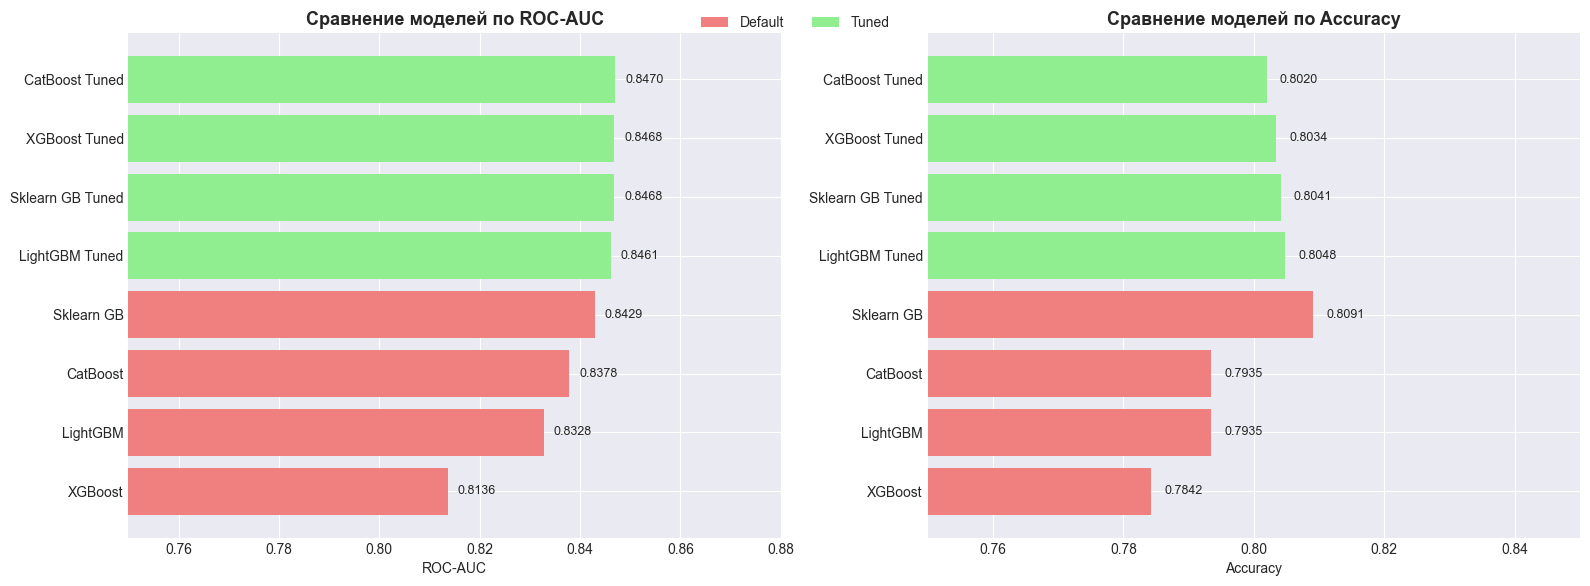

In [75]:
# Визуализация финального сравнения
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# График ROC-AUC
colors = ['lightcoral' if t == 'Default' else 'lightgreen' for t in final_results['Type']]
axes[0].barh(range(len(final_results)), final_results['ROC-AUC'], color=colors)
axes[0].set_yticks(range(len(final_results)))
axes[0].set_yticklabels(final_results['Model'])
axes[0].set_xlabel('ROC-AUC')
axes[0].set_title('Сравнение моделей по ROC-AUC', fontweight='bold', fontsize=13)
axes[0].set_xlim([0.75, 0.88])
axes[0].invert_yaxis()

# Добавляем значения на график
for i, v in enumerate(final_results['ROC-AUC']):
    axes[0].text(v + 0.002, i, f'{v:.4f}', va='center', fontsize=9)

# График Accuracy
axes[1].barh(range(len(final_results)), final_results['Accuracy'], color=colors)
axes[1].set_yticks(range(len(final_results)))
axes[1].set_yticklabels(final_results['Model'])
axes[1].set_xlabel('Accuracy')
axes[1].set_title('Сравнение моделей по Accuracy', fontweight='bold', fontsize=13)
axes[1].set_xlim([0.75, 0.85])
axes[1].invert_yaxis()

# Добавляем значения на график
for i, v in enumerate(final_results['Accuracy']):
    axes[1].text(v + 0.002, i, f'{v:.4f}', va='center', fontsize=9)

# Легенда
from matplotlib.patches import Patch
legend_elements = [Patch(facecolor='lightcoral', label='Default'),
                  Patch(facecolor='lightgreen', label='Tuned')]
fig.legend(handles=legend_elements, loc='upper center', ncol=2, bbox_to_anchor=(0.5, 0.98))

plt.tight_layout()
plt.subplots_adjust(top=0.93)
plt.show()

In [76]:
# Сравнение улучшения после настройки
improvement = pd.DataFrame({
    'Model': ['Sklearn GB', 'XGBoost', 'CatBoost', 'LightGBM'],
    'Default ROC-AUC': [results['Sklearn_GB_default']['roc_auc'], results['XGBoost_default']['roc_auc'],
                       results['CatBoost_default']['roc_auc'], results['LightGBM_default']['roc_auc']],
    'Tuned ROC-AUC': [results['Sklearn_GB_tuned']['roc_auc'], results['XGBoost_tuned']['roc_auc'],
                     results['CatBoost_tuned']['roc_auc'], results['LightGBM_tuned']['roc_auc']]
})

improvement['Improvement'] = improvement['Tuned ROC-AUC'] - improvement['Default ROC-AUC']
improvement['Improvement %'] = (improvement['Improvement'] / improvement['Default ROC-AUC'] * 100)

print('\n' + '='*80)
print('УЛУЧШЕНИЕ ПОСЛЕ НАСТРОЙКИ ГИПЕРПАРАМЕТРОВ')
print('='*80)
print(improvement.to_string(index=False))
print('='*80)


УЛУЧШЕНИЕ ПОСЛЕ НАСТРОЙКИ ГИПЕРПАРАМЕТРОВ
     Model  Default ROC-AUC  Tuned ROC-AUC  Improvement  Improvement %
Sklearn GB         0.842937       0.846760     0.003823       0.453581
   XGBoost         0.813583       0.846820     0.033236       4.085194
  CatBoost         0.837791       0.847006     0.009215       1.099906
  LightGBM         0.832795       0.846064     0.013270       1.593373


## Выводы

### Часть 1: EDA
- Датасет содержит 7043 записи о клиентах телекоммуникационной компании
- Целевая переменная (Churn) несбалансирована: 26.54% отток, 73.46% удержание
- Выявлены ключевые факторы оттока: тип контракта, наличие технической поддержки, способ оплаты, срок пользования услугами
- Клиенты с краткосрочными контрактами (month-to-month) чаще уходят
- Обнаружены проблемы в данных: TotalCharges содержал нечисловые значения, требующие обработки

### Часть 2: Preprocessing & Feature Engineering
- Созданы новые признаки: средняя стоимость за месяц (AvgMonthlyCharges), количество услуг (ServiceCount), группы по продолжительности (TenureGroup)
- Все категориальные переменные закодированы с помощью LabelEncoder
- Данные разделены на train/test (80/20) с сохранением пропорций классов (stratify)

### Часть 3: Сравнение градиентных бустингов

**Результаты моделей "из коробки":**
- Sklearn GradientBoosting показал лучший результат: ROC-AUC 0.8429
- CatBoost: ROC-AUC 0.8378
- LightGBM: ROC-AUC 0.8328
- XGBoost: ROC-AUC 0.8136
- Неожиданно, классическая реализация sklearn превзошла современные библиотеки без настройки

**После настройки гиперпараметров:**
- CatBoost Tuned: ROC-AUC 0.8470 (улучшение +1.10%)
- XGBoost Tuned: ROC-AUC 0.8468 (улучшение +4.09%)
- Sklearn GB Tuned: ROC-AUC 0.8468 (улучшение +0.45%)
- LightGBM Tuned: ROC-AUC 0.8461 (улучшение +1.59%)
- XGBoost получил максимальную пользу от тюнинга гиперпараметров
- Sklearn GradientBoosting практически не улучшился, дефолтные параметры уже близки к оптимальным
- Топ-3 модели показали практически идентичные результаты (разница 0.0002)

**Итоговый победитель:**
- CatBoost (Tuned): ROC-AUC 0.8470, Accuracy 0.8020
- Лучший результат по метрике ROC-AUC среди всех моделей
- Встроенная обработка категориальных признаков
- Устойчив к переобучению

**Сравнение библиотек:**
- Sklearn GradientBoosting: простота, хороший baseline, медленный на больших данных
- XGBoost: гибкость настройки, лучше всех реагирует на тюнинг, требует подбора параметров
- CatBoost: отличная работа с категориальными признаками, лучшее итоговое качество
- LightGBM: самая высокая скорость обучения, эффективен для больших датасетов
